In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")

In [2]:
import os
import sys
sys.path.append("/Users/jiqi/Documents/GitHub/CBB750/")

# Data Preprocess

In [3]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count

def clean_text(text): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist) 

# Define a function to perform chi-square test and select top k features
def chi2_feature_selection(X, y, k):
    selector = SelectKBest(score_func=chi2, k=k)
    selector.fit(X, y)
    selected_indices = selector.get_support(indices=True)
    selected_features = X[:, selected_indices]
    
    # Convert selected features to binary values
    selected_features[selected_features > 0] = 1
    
    # Compute contingency table and p-values
    contingency_table = np.vstack([selected_features[y == label].sum(axis=0) for label in np.unique(y)])
    _, p_values, _, _ = chi2_contingency(contingency_table)
    
    return selected_indices, p_values

# Define a function to print classification metrics
def print_classification_metrics(y_true, y_pred, target_names):
    print('Accuracy: {:.3f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:.3f}'.format(precision_score(y_true, y_pred, average='weighted')))
    print('Recall: {:.3f}'.format(recall_score(y_true, y_pred, average='weighted')))
    print('F1-score: {:.3f}'.format(f1_score(y_true, y_pred, average='weighted')))
    print('Classification Report:\n', classification_report(y_true, y_pred, target_names=target_names))


In [6]:
import pandas as pd

IG_P = pd.read_excel('./Code by message type.xlsx', sheet_name='Info Giving - Patient')
IG_C = pd.read_excel('./Code by message type.xlsx', sheet_name='Info Giving - Clinician')
IG_A = pd.read_excel('./Code by message type.xlsx', sheet_name='Info Giving - Auto')

IS_C = pd.read_excel('./Code by message type.xlsx', sheet_name='Info Seek - Clinician')
IS_P = pd.read_excel('./Code by message type.xlsx', sheet_name='Info Seek - Patient')

Emo_P = pd.read_excel('./Code by message type.xlsx', sheet_name='Emotion - Patient')
Emo_C = pd.read_excel('./Code by message type.xlsx', sheet_name='Emotion - Clinician')

P_C = pd.read_excel('./Code by message type.xlsx', sheet_name='Partnership - Clinician')
P_P = pd.read_excel('./Code by message type.xlsx', sheet_name='Partnership - Patient')

In [7]:
# Combine IG_P, IG_C, IG_A into one dataframe
IG = pd.concat([IG_P, IG_C, IG_A], axis=0, ignore_index=True)
IG
# Combine IS_C, IS_P into one dataframe
IS = pd.concat([IS_C, IS_P], axis=0, ignore_index=True)

# Combine Emo_P, Emo_C into one dataframe
Emo = pd.concat([Emo_P, Emo_C], axis=0, ignore_index=True)

# Combine P_C, P_P into one dataframe
P = pd.concat([P_C, P_P], axis=0, ignore_index=True)


In [41]:
# Add labels to each dataframe
IG['Label'] = 'Info Giving'
IS['Label'] = 'Info Seeking'
Emo['Label'] = 'Emotion'
P['Label'] = 'Partnership'

# Combine all dataframes into one dataframe
df = pd.concat([IG, IS, Emo, P], axis=0, ignore_index=True)
# drop the columns that are not needed
df = df.drop(['Unnamed: 2'], axis=1)
# rename the columns

df.columns = ['Message', 'Code', 'Label']
df.loc[:, "Code"][df.loc[:, "Code"] == 'Clinician\nInformation-Giving'] = "Clinician"
df.to_csv('DataMessageLabelCode.csv', index=False)

Number of sentences in transcriptions column: 270
Number of unique words in transcriptions column: 1537
===========Original Categories =======================
Cat:1 Emotion : 32
Cat:2 Info Giving : 159
Cat:3 Info Seeking : 61
Cat:4 Partnership : 18
============Reduced Categories ======================
Cat:1 Emotion : 32
Cat:2 Info Giving : 159
Cat:3 Info Seeking : 61
Cat:4 Partnership : 18
============ Reduced Categories ======================


[nltk_data] Downloading package punkt to /Users/jiqi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


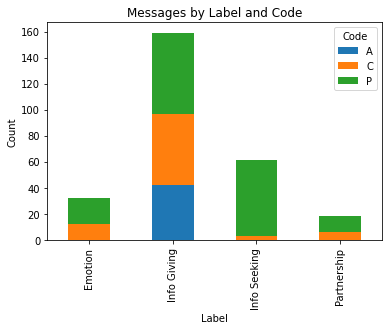

In [7]:
import nltk
nltk.download('punkt')
df = pd.read_csv('DataMessageLabelCode.csv')
df = df[df['Message'].notna()]
replacements = {'Auto': 'A', 'Patient': 'P', 'Clinician': 'C'}

# replace the values in the specified column
df['Code'] = df['Code'].replace(replacements)

sent_count,word_count= get_sentence_word_count(df['Message'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))


data_categories  = df.groupby(df['Label'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 10)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['Label'])
i=1
print('============Reduced Categories ======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============ Reduced Categories ======================')

# Group the data by Label and Code and count the number of messages in each group
grouped_data = df.groupby(['Label', 'Code'])['Message'].count()

# Convert the grouped data to a DataFrame
grouped_df = grouped_data.to_frame().reset_index()

# Create a pivot table to reshape the data for plotting
pivot_df = grouped_df.pivot(index='Label', columns='Code', values='Message')

# Create a bar plot of the data
pivot_df.plot(kind='bar', stacked=True)
plt.ylabel('Count')
plt.title('Messages by Label and Code')
plt.show()

[nltk_data] Downloading package stopwords to /Users/jiqi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jiqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Train_Set_Size:(202, 116)
Test_Set_Size:(68, 116)


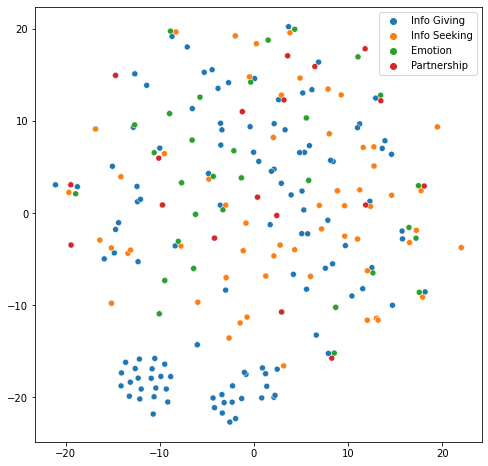

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# define the lemmatizer
lemmatizer = WordNetLemmatizer()

# define a function to clean and lemmatize text using nltk
def clean_and_lemmatize_text(text):
    # tokenize the text into words
    words = nltk.word_tokenize(text)
    
    # remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    
    # lemmatize the words
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # join the words back into a string
    cleaned_text = ' '.join(words)
    
    return cleaned_text

# apply the clean and lemmatize function to the 'Message' column
data = df.copy()
data['Message'] = data['Message'].apply(clean_and_lemmatize_text)

# use the tf-idf vectorizer with the cleaned and lemmatized text
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['Message'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())

import gc
gc.collect()
tfIdfMatrix = np.asarray(tfIdfMat.todense())
labels = data['Label'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(8,8))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    legend="full",
    alpha=1
)

gc.collect()
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['Label'].tolist()
category_list = data.Label.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))  

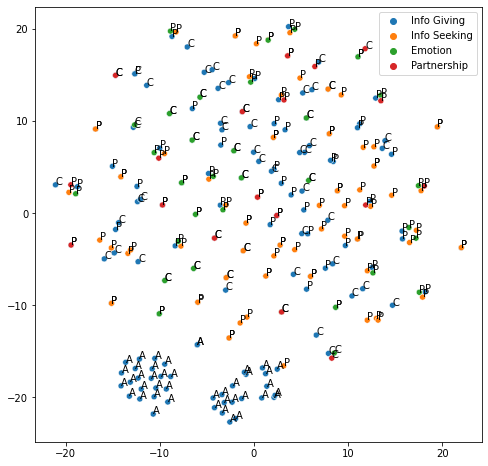

In [9]:
plt.figure(figsize=(8,8))

sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    legend="full",
    alpha=1
)
for i, txt in enumerate(data['Code']):
    plt.annotate(txt, (tsne_results[:,0][i], tsne_results[:,1][i]))
plt.show()

# Baseline

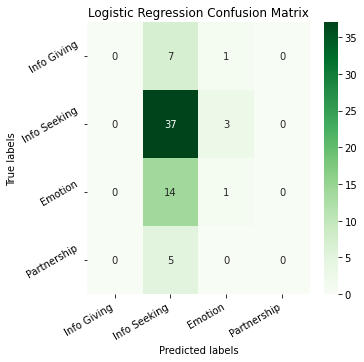

              precision    recall  f1-score   support

 Info Giving       0.59      0.93      0.72        40
Info Seeking       0.20      0.07      0.10        15
     Emotion       0.00      0.00      0.00         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.56        68
   macro avg       0.20      0.25      0.20        68
weighted avg       0.39      0.56      0.44        68



In [28]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf_lr.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)
fig = plt.figure(figsize=(5,5))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Logistic Regression Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

print(classification_report(y_test,y_test_pred,labels=category_list))

Best hyperparameters: {'l1_ratio': 0, 'penalty': 'l1', 'solver': 'saga'}
Best score: 0.5991463414634147


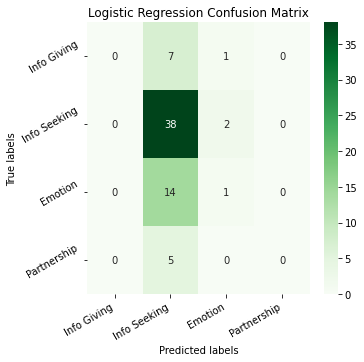

              precision    recall  f1-score   support

 Info Giving       0.59      0.95      0.73        40
Info Seeking       0.25      0.07      0.11        15
     Emotion       0.00      0.00      0.00         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.57        68
   macro avg       0.21      0.25      0.21        68
weighted avg       0.40      0.57      0.45        68



In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

# create the logistic regression classifier
clf_lr = LogisticRegression(random_state=1)

# perform grid search with cross-validation
grid_search = GridSearchCV(clf_lr, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# print the best hyperparameters and score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# predict using the best estimator
y_test_pred = grid_search.best_estimator_.predict(X_test)

# print the confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

labels = category_list
cm = confusion_matrix(y_test, y_test_pred)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens", ax=ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Logistic Regression Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

print(classification_report(y_test, y_test_pred, labels=category_list))


Best hyperparameters: {'l1_ratio': 0, 'penalty': 'l2', 'solver': 'saga'}
Best score: 0.7732894736842104


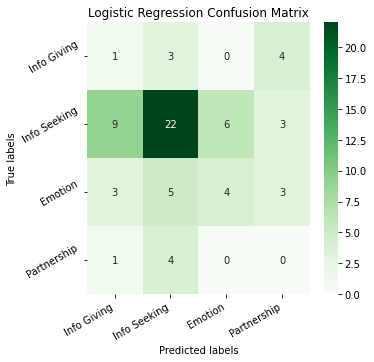

              precision    recall  f1-score   support

 Info Giving       0.65      0.55      0.59        40
Info Seeking       0.40      0.27      0.32        15
     Emotion       0.07      0.12      0.09         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.40        68
   macro avg       0.28      0.24      0.25        68
weighted avg       0.48      0.40      0.43        68



In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

# perform SMOTE to handle data imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# create the logistic regression classifier
clf_lr = LogisticRegression(random_state=1)

# perform grid search with cross-validation
grid_search = GridSearchCV(clf_lr, param_grid, cv=5)
grid_search.fit(X_train_res, y_train_res)

# print the best hyperparameters and score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# predict using the best estimator
y_test_pred = grid_search.best_estimator_.predict(X_test)

# print the confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

labels = category_list
cm = confusion_matrix(y_test, y_test_pred)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens", ax=ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Logistic Regression Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

print(classification_report(y_test, y_test_pred, labels=category_list))


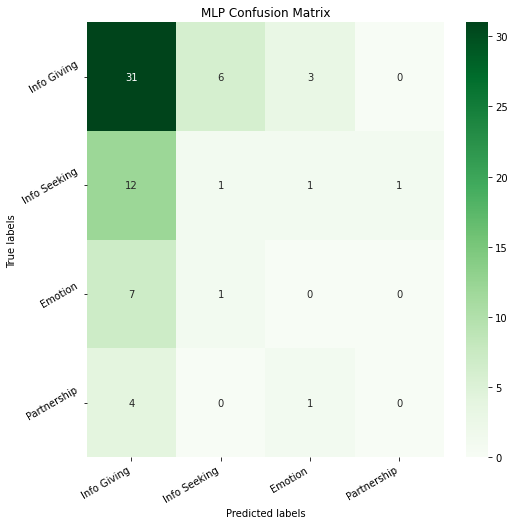

              precision    recall  f1-score   support

 Info Giving       0.57      0.78      0.66        40
Info Seeking       0.12      0.07      0.09        15
     Emotion       0.00      0.00      0.00         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.47        68
   macro avg       0.17      0.21      0.19        68
weighted avg       0.37      0.47      0.41        68



In [30]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_test_pred= clf_mlp.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('MLP Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

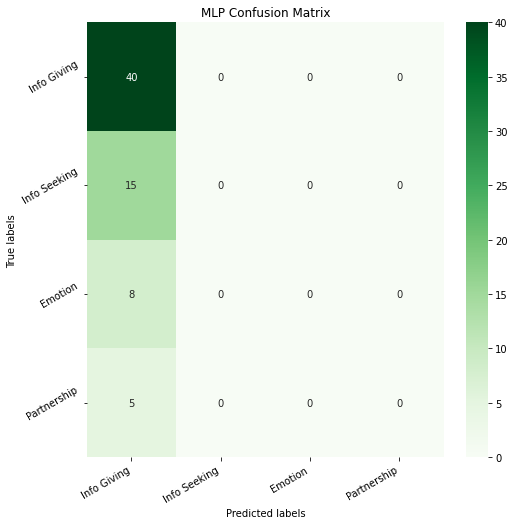

              precision    recall  f1-score   support

 Info Giving       0.59      1.00      0.74        40
Info Seeking       0.00      0.00      0.00        15
     Emotion       0.00      0.00      0.00         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.59        68
   macro avg       0.15      0.25      0.19        68
weighted avg       0.35      0.59      0.44        68



In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'hidden_layer_sizes': [(50,), (50,50), (100,50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate': ['adaptive'],
    'max_iter': [200, 300]
}

# Create an MLP classifier
mlp = MLPClassifier(random_state=1)

# Create a grid search object with 5-fold cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the MLP classifier with the best parameters on the training data
clf_mlp = MLPClassifier(random_state=1, **best_params).fit(X_train, y_train)

# Predict on the test data
y_test_pred = clf_mlp.predict(X_test)

# Print the confusion matrix and classification report
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens", ax=ax, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('MLP Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

print(classification_report(y_test, y_test_pred, labels=category_list))

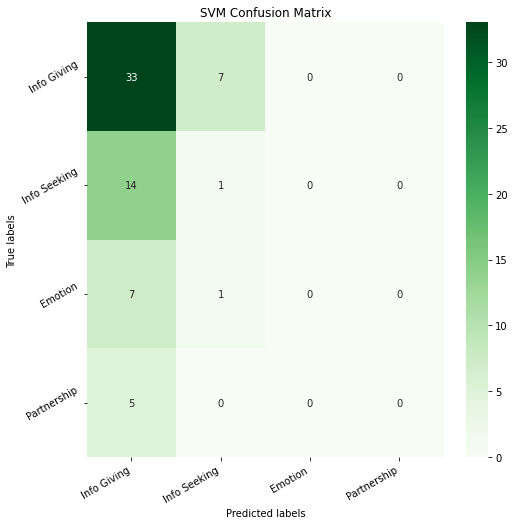

              precision    recall  f1-score   support

 Info Giving       0.56      0.82      0.67        40
Info Seeking       0.11      0.07      0.08        15
     Emotion       0.00      0.00      0.00         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.50        68
   macro avg       0.17      0.22      0.19        68
weighted avg       0.35      0.50      0.41        68



In [10]:
from sklearn.svm import SVC
clf_svm = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, break_ties=False).fit(X_train, y_train)
y_test_pred= clf_svm.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('SVM Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

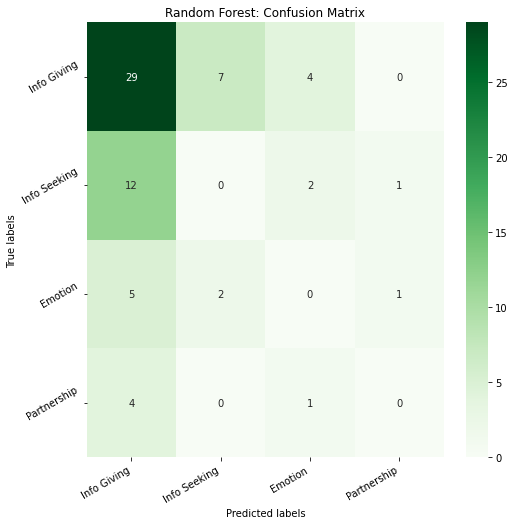

              precision    recall  f1-score   support

 Info Giving       0.58      0.72      0.64        40
Info Seeking       0.00      0.00      0.00        15
     Emotion       0.00      0.00      0.00         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.43        68
   macro avg       0.14      0.18      0.16        68
weighted avg       0.34      0.43      0.38        68



In [11]:
from sklearn.ensemble import RandomForestClassifier
clf_rc = RandomForestClassifier().fit(X_train, y_train)
y_test_pred= clf_rc.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Random Forest: Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

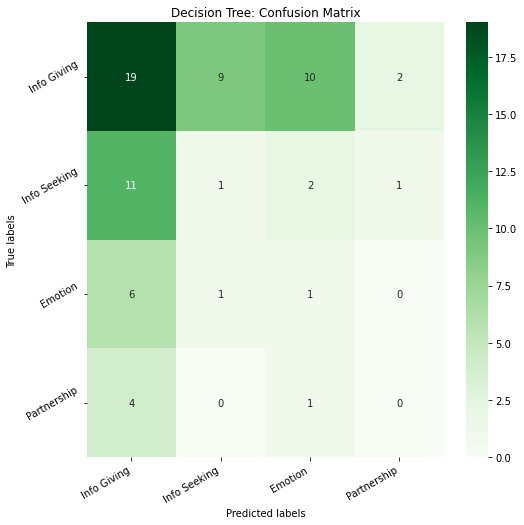

              precision    recall  f1-score   support

 Info Giving       0.47      0.47      0.48        40
Info Seeking       0.09      0.07      0.08        15
     Emotion       0.07      0.12      0.09         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.31        68
   macro avg       0.16      0.17      0.16        68
weighted avg       0.31      0.31      0.31        68



In [13]:
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier().fit(X_train, y_train)
y_test_pred= clf_dt.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Decision Tree: Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

# Binary Classification Model

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.630
Precision: 0.642
Recall: 0.630
F1-score: 0.561
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.62      0.94      0.75        32
Non-Info-giving       0.67      0.18      0.29        22

       accuracy                           0.63        54
      macro avg       0.65      0.56      0.52        54
   weighted avg       0.64      0.63      0.56        54

Selected features: android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, coronavirus, covid, dad, date, dawn, department, dept, devine, encouraged, extent, face, floor, gt, haven, href, http, infected, information, level, lt, moved, mychart, north, pm, prepare, procedure, provider, questionnaire, recovery, scan, smilow, street, surgery, symptom, time, type, video, vimeo, visit, visiting, visitor, visits, wait

Performing binary classification for task: Info-

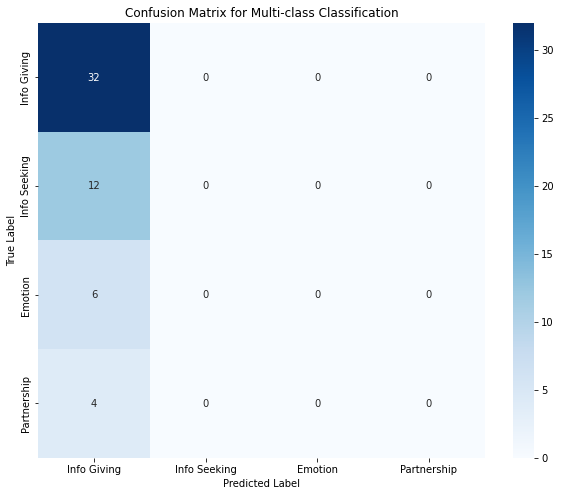

Classification Report:
              precision    recall  f1-score   support

 Info Giving       0.00      0.00      0.00         6
Info Seeking       0.59      1.00      0.74        32
     Emotion       0.00      0.00      0.00        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.59        54
   macro avg       0.15      0.25      0.19        54
weighted avg       0.35      0.59      0.44        54

Top 200 features:
1 prepare
2 posted
3 concern
4 smilow
5 feeling
6 team
7 provider
8 june
9 sure
10 north
11 calcium
12 inquiring
13 decided
14 renewed
15 ll
16 face
17 cancel
18 vimeo
19 thinner
20 gi
21 forgot
22 advise
23 lomotil
24 heart
25 perscription
26 psa
27 luck
28 surgery
29 uploaded
30 23rd
31 prostrate
32 took
33 renewal
34 questionnaire
35 recovery
36 dept
37 hour
38 shot
39 hormone
40 moved
41 think
42 carry
43 symptom
44 com400253143a5b439d1cc
45 study
46 father
47 sugar
48 eligible
49 coordinate
50 used
51 street
52 av

In [10]:
# Load the data into a DataFrame
df = data

# Define binary classification tasks
binary_tasks = {
    'Info-giving vs. Non-Info-giving': ['Info Giving', 'Non-Info-giving'],
    'Info-seeking vs. Non-info-seeking': ['Info Seeking', 'Non-info-seeking'],
    'Emotion vs. non-emotion': ['Emotion', 'Non-emotion'],
    'Partnership vs. non-partnership': ['Partnership', 'Non-partnership']
}

# Perform binary classification tasks
top_k = 50  # Number of top features to select for each binary classification
selected_features = []
for task_name, labels in binary_tasks.items():
    print('Performing binary classification for task:', task_name)
    X = df['Message'].values
    y = df['Label'].apply(lambda x: labels[0] if x == labels[0] else labels[1]).values

    # Convert text data to TF-IDF features
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(X)

    # Perform feature selection using chi-square test
    selected_indices, p_values = chi2_feature_selection(X, y, top_k)
    selected_features += [vectorizer.get_feature_names()[i] for i in selected_indices]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

        # Train a logistic regression model
    lr = LogisticRegression(max_iter=1000)
    param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
    clf = GridSearchCV(lr, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train[:, selected_indices], y_train)

    # Evaluate the model on the testing set
    y_pred = clf.predict(X_test[:, selected_indices])
    target_names = [labels[0], labels[1]]
    print_classification_metrics(y_test, y_pred, target_names)
    print('Selected features:', ', '.join([vectorizer.get_feature_names()[i] for i in selected_indices]))
    print('')

# Perform multi-class classification using selected features
top_k *= 4  # Increase the number of top features to include all selected features from binary classification tasks
selected_features = list(set(selected_features))[:top_k]
print('Performing multi-class classification using top {} features:'.format(top_k))
X = df['Message'].values
y = df['Label'].values

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', vocabulary=selected_features)
X = vectorizer.fit_transform(X)
feature_names = vectorizer.get_feature_names()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Train a logistic regression model
lr = LogisticRegression(max_iter=1000)
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
clf = GridSearchCV(lr, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
clf.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = clf.predict(X_test)
# Get the unique label names in the order of the classes
label_list = df['Label'].unique()

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=label_list)

# Create a heatmap of the confusion matrix with label names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Multi-class Classification')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=label_list))
print('Top 200 features:')
for i, feature in enumerate(feature_names[:200]):
    print(i+1, feature)


Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.593
Precision: 0.562
Recall: 0.593
F1-score: 0.517
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.60      0.91      0.72        32
Non-Info-giving       0.50      0.14      0.21        22

       accuracy                           0.59        54
      macro avg       0.55      0.52      0.47        54
   weighted avg       0.56      0.59      0.52        54

Selected features: android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, coronavirus, covid, dad, date, dawn, department, dept, devine, encouraged, extent, face, floor, gt, haven, href, http, infected, information, level, lt, moved, mychart, north, pm, prepare, procedure, provider, questionnaire, recovery, scan, smilow, street, surgery, symptom, time, type, video, vimeo, visit, visiting, visitor, visits, wait

Performing binary classification for task: Info-

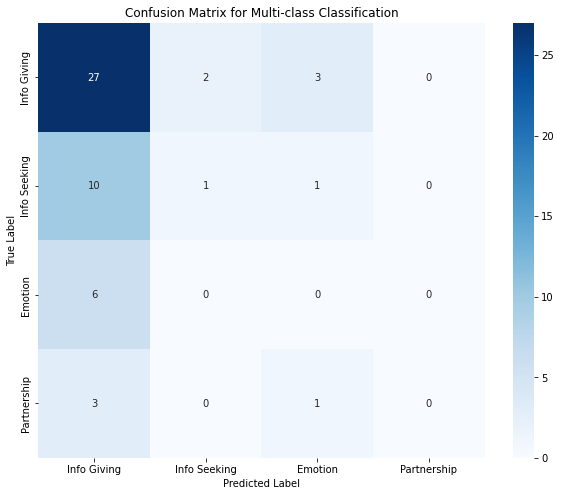

Classification Report:
              precision    recall  f1-score   support

 Info Giving       0.00      0.00      0.00         6
Info Seeking       0.59      0.84      0.69        32
     Emotion       0.33      0.08      0.13        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.52        54
   macro avg       0.23      0.23      0.21        54
weighted avg       0.42      0.52      0.44        54

Top 200 features:
1 prepare
2 posted
3 concern
4 smilow
5 feeling
6 team
7 provider
8 june
9 sure
10 north
11 calcium
12 inquiring
13 decided
14 renewed
15 ll
16 face
17 cancel
18 vimeo
19 thinner
20 gi
21 forgot
22 advise
23 lomotil
24 heart
25 perscription
26 psa
27 luck
28 surgery
29 uploaded
30 23rd
31 prostrate
32 took
33 renewal
34 questionnaire
35 recovery
36 dept
37 hour
38 shot
39 hormone
40 moved
41 think
42 carry
43 symptom
44 com400253143a5b439d1cc
45 study
46 father
47 sugar
48 eligible
49 coordinate
50 used
51 street
52 av

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Perform binary classification tasks
top_k = 50  # Number of top features to select for each binary classification
selected_features = []
for task_name, labels in binary_tasks.items():
    print('Performing binary classification for task:', task_name)
    X = df['Message'].values
    y = df['Label'].apply(lambda x: labels[0] if x == labels[0] else labels[1]).values

    # Convert text data to TF-IDF features
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(X)

    # Perform feature selection using chi-square test
    selected_indices, p_values = chi2_feature_selection(X, y, top_k)
    selected_features += [vectorizer.get_feature_names()[i] for i in selected_indices]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

    # Train a decision tree model
    dt = DecisionTreeClassifier()
    param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20]}
    clf = GridSearchCV(dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train[:, selected_indices], y_train)

    # Evaluate the model on the testing set
    y_pred = clf.predict(X_test[:, selected_indices])
    target_names = [labels[0], labels[1]]
    print_classification_metrics(y_test, y_pred, target_names)
    print('Selected features:', ', '.join([vectorizer.get_feature_names()[i] for i in selected_indices]))
    print('')

# Perform multi-class classification using selected features
top_k *= 4  # Increase the number of top features to include all selected features from binary classification tasks
selected_features = list(set(selected_features))[:top_k]
print('Performing multi-class classification using top {} features:'.format(top_k))
X = df['Message'].values
y = df['Label'].values

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', vocabulary=selected_features)
X = vectorizer.fit_transform(X)
feature_names = vectorizer.get_feature_names()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Train a decision tree model
dt = DecisionTreeClassifier()
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20]}
clf = GridSearchCV(dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
clf.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = clf.predict(X_test)
# Get the unique label names in the order of the classes
label_list = df['Label'].unique()

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=label_list)

# Create a heatmap of the confusion matrix with label names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Multi-class Classification')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=label_list))
print('Top 200 features:')
for i, feature in enumerate(feature_names[:200]):
    print(i+1, feature)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.593
Precision: 0.567
Recall: 0.593
F1-score: 0.548
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.61      0.84      0.71        32
Non-Info-giving       0.50      0.23      0.31        22

       accuracy                           0.59        54
      macro avg       0.56      0.54      0.51        54
   weighted avg       0.57      0.59      0.55        54

Selected features: android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, coronavirus, covid, dad, date, dawn, department, dept, devine, encouraged, extent, face, floor, gt, haven, href, http, infected, information, level, lt, moved, mychart, north, pm, prepare, procedure, provider, questionnaire, recovery, scan, smilow, street, surgery, symptom, time, type, video, vimeo, visit, visiting, visitor, visits, wait

Performing binary classification for task: Info-

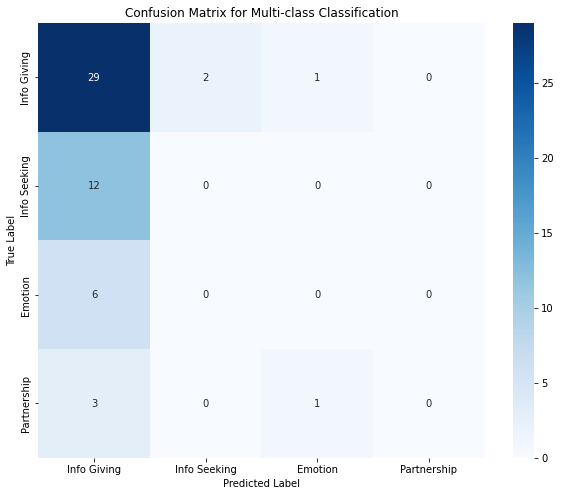

Classification Report:
              precision    recall  f1-score   support

 Info Giving       0.00      0.00      0.00         6
Info Seeking       0.58      0.91      0.71        32
     Emotion       0.00      0.00      0.00        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.54        54
   macro avg       0.14      0.23      0.18        54
weighted avg       0.34      0.54      0.42        54

Top 200 features:
1 prepare
2 posted
3 concern
4 smilow
5 feeling
6 team
7 provider
8 june
9 sure
10 north
11 calcium
12 inquiring
13 decided
14 renewed
15 ll
16 face
17 cancel
18 vimeo
19 thinner
20 gi
21 forgot
22 advise
23 lomotil
24 heart
25 perscription
26 psa
27 luck
28 surgery
29 uploaded
30 23rd
31 prostrate
32 took
33 renewal
34 questionnaire
35 recovery
36 dept
37 hour
38 shot
39 hormone
40 moved
41 think
42 carry
43 symptom
44 com400253143a5b439d1cc
45 study
46 father
47 sugar
48 eligible
49 coordinate
50 used
51 street
52 av

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Perform binary classification tasks
top_k = 50  # Number of top features to select for each binary classification
selected_features = []
for task_name, labels in binary_tasks.items():
    print('Performing binary classification for task:', task_name)
    X = df['Message'].values
    y = df['Label'].apply(lambda x: labels[0] if x == labels[0] else labels[1]).values

    # Convert text data to TF-IDF features
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(X)

    # Perform feature selection using chi-square test
    selected_indices, p_values = chi2_feature_selection(X, y, top_k)
    selected_features += [vectorizer.get_feature_names()[i] for i in selected_indices]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

    # Train a random forest model
    rf = RandomForestClassifier(n_estimators=100)
    param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20]}
    clf = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train[:, selected_indices], y_train)

    # Evaluate the model on the testing set
    y_pred = clf.predict(X_test[:, selected_indices])
    target_names = [labels[0], labels[1]]
    print_classification_metrics(y_test, y_pred, target_names)
    print('Selected features:', ', '.join([vectorizer.get_feature_names()[i] for i in selected_indices]))
    print('')

# Perform multi-class classification using selected features
top_k *= 4  # Increase the number of top features to include all selected features from binary classification tasks
selected_features = list(set(selected_features))[:top_k]
print('Performing multi-class classification using top {} features:'.format(top_k))
X = df['Message'].values
y = df['Label'].values

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', vocabulary=selected_features)
X = vectorizer.fit_transform(X)
feature_names = vectorizer.get_feature_names()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Train a random forest model
rf = RandomForestClassifier(n_estimators=100)
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20]}
clf = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
clf.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = clf.predict(X_test)

# Get the unique label names in the order of the classes
label_list = df['Label'].unique()

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=label_list)

# Create a heatmap of the confusion matrix with label names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Multi-class Classification')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=label_list))
print('Top 200 features:')
for i, feature in enumerate(feature_names[:200]):
    print(i+1, feature)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.593
Precision: 0.557
Recall: 0.593
F1-score: 0.471
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.60      0.97      0.74        32
Non-Info-giving       0.50      0.05      0.08        22

       accuracy                           0.59        54
      macro avg       0.55      0.51      0.41        54
   weighted avg       0.56      0.59      0.47        54

Selected features: visit, video, provider, prepare, lt, gt, mychart, information, date, href, vimeo, type, http, time, dept, appt, covid, face, devine, haven, north, pm, procedure, questionnaire, recovery, wait, department, cancel, dawn, infected, symptom, coronavirus, street, smilow, level, apple, android, encouraged, visitor, extent, visits, bring, moved, com4002532083e3d356236, com400253143a5b439d1cc, floor, dad, scan, visiting, surgery

Performing binary classification for task: Info-

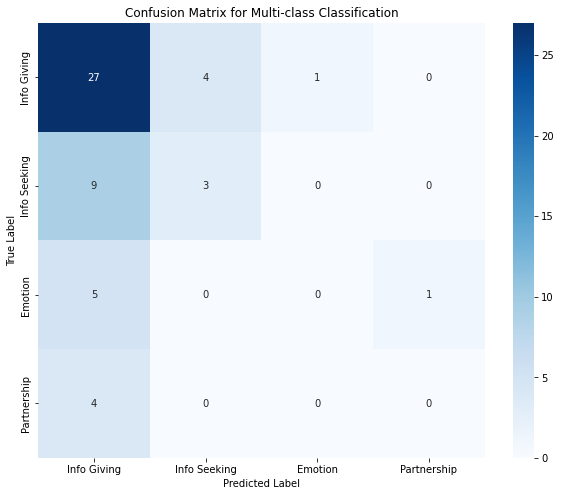

Classification Report:
              precision    recall  f1-score   support

 Info Giving       0.00      0.00      0.00         6
Info Seeking       0.60      0.84      0.70        32
     Emotion       0.43      0.25      0.32        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.56        54
   macro avg       0.26      0.27      0.25        54
weighted avg       0.45      0.56      0.49        54

Top 200 features:
1 prepare
2 posted
3 concern
4 smilow
5 feeling
6 team
7 provider
8 june
9 sure
10 north
11 calcium
12 inquiring
13 decided
14 ll
15 face
16 cancel
17 vimeo
18 thinner
19 gi
20 forgot
21 advise
22 lomotil
23 heart
24 perscription
25 psa
26 luck
27 surgery
28 uploaded
29 23rd
30 prostrate
31 took
32 renewal
33 questionnaire
34 recovery
35 dept
36 hour
37 shot
38 hormone
39 moved
40 associated
41 think
42 carry
43 symptom
44 com400253143a5b439d1cc
45 study
46 father
47 sugar
48 eligible
49 coordinate
50 used
51 street
52

In [18]:
from sklearn.preprocessing import LabelEncoder

# Load the data into a DataFrame
df = data

# Define binary classification tasks
binary_tasks = {
    'Info-giving vs. Non-Info-giving': ['Info Giving', 'Non-Info-giving'],
    'Info-seeking vs. Non-info-seeking': ['Info Seeking', 'Non-info-seeking'],
    'Emotion vs. non-emotion': ['Emotion', 'Non-emotion'],
    'Partnership vs. non-partnership': ['Partnership', 'Non-partnership']
}

# Perform binary classification tasks
top_k = 50  # Number of top features to select for each binary classification
selected_features = []
for task_name, labels in binary_tasks.items():
    print('Performing binary classification for task:', task_name)
    X = df['Message'].values
    y = df['Label'].apply(lambda x: labels[0] if x == labels[0] else labels[1]).values

    # Convert text data to TF-IDF features
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(X)

    # Perform feature selection using chi-square test
    selected_indices, p_values = chi2(X, y)
    selected_indices = selected_indices.argsort()[::-1][:top_k]
    selected_features += [vectorizer.get_feature_names()[i] for i in selected_indices]

    # Convert labels to numeric
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

    # Train an XGBoost model
    xgb_model = xgb.XGBClassifier()
    param_grid = {'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.001]}
    clf = GridSearchCV(xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train[:, selected_indices], y_train)

    # Evaluate the model on the testing set
    y_pred = clf.predict(X_test[:, selected_indices])
    target_names = [labels[0], labels[1]]
    print_classification_metrics(y_test, y_pred, target_names)
    print('Selected features:', ', '.join([vectorizer.get_feature_names()[i] for i in selected_indices]))
    print('')

# Perform multi-class classification using selected features
top_k *= 4  # Increase the number of top features to include all selected features from binary classification tasks
selected_features = list(set(selected_features))[:top_k]
print('Performing multi-class classification using top {} features:'.format(top_k))
X = df['Message'].values
y = df['Label'].values

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', vocabulary=selected_features)
X = vectorizer.fit_transform(X)
feature_names = vectorizer.get_feature_names()

# Convert labels to numeric
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Train an XGBoost model
xgb_model = xgb.XGBClassifier()
param_grid = {'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.001]}
clf = GridSearchCV(xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
clf.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = clf.predict(X_test)

# Convert numeric labels back to original labels
y_test = le.inverse_transform(y_test)
y_pred = le.inverse_transform(y_pred)

# Get the unique label names in the order of the classes
label_list = df['Label'].unique()

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=label_list)

# Create a heatmap of the confusion matrix with label names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Multi-class Classification')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=label_list))
print('Top 200 features:')
for i, feature in enumerate(feature_names[:200]):
    print(i+1, feature)



Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.574
Precision: 0.514
Recall: 0.574
F1-score: 0.485
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.59      0.91      0.72        32
Non-Info-giving       0.40      0.09      0.15        22

       accuracy                           0.57        54
      macro avg       0.50      0.50      0.43        54
   weighted avg       0.51      0.57      0.48        54

Selected features: visit, video, provider, prepare, lt, gt, mychart, information, date, href, vimeo, type, http, time, dept, appt, covid, face, devine, haven, north, pm, procedure, questionnaire, recovery, wait, department, cancel, dawn, infected, symptom, coronavirus, street, smilow, level, apple, android, encouraged, visitor, extent, visits, bring, moved, com4002532083e3d356236, com400253143a5b439d1cc, floor, dad, scan, visiting, surgery

Performing binary classification for task: Info-

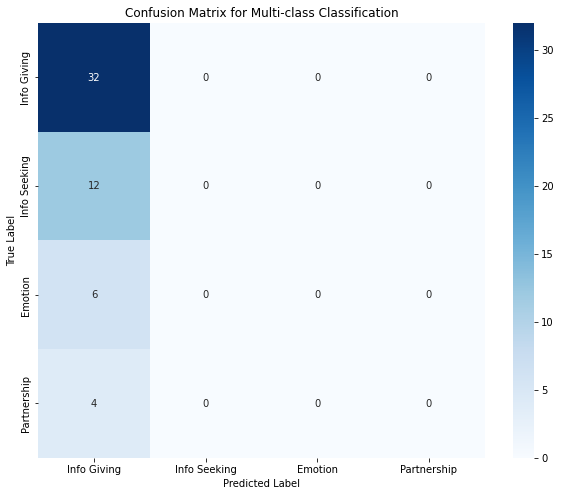

Classification Report:
              precision    recall  f1-score   support

 Info Giving       0.00      0.00      0.00         6
Info Seeking       0.59      1.00      0.74        32
     Emotion       0.00      0.00      0.00        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.59        54
   macro avg       0.15      0.25      0.19        54
weighted avg       0.35      0.59      0.44        54

Top 200 features:
1 prepare
2 posted
3 concern
4 smilow
5 feeling
6 team
7 provider
8 june
9 sure
10 north
11 calcium
12 inquiring
13 decided
14 ll
15 face
16 cancel
17 vimeo
18 thinner
19 gi
20 forgot
21 advise
22 lomotil
23 heart
24 perscription
25 psa
26 luck
27 surgery
28 uploaded
29 23rd
30 prostrate
31 took
32 renewal
33 questionnaire
34 recovery
35 dept
36 hour
37 shot
38 hormone
39 moved
40 associated
41 think
42 carry
43 symptom
44 com400253143a5b439d1cc
45 study
46 father
47 sugar
48 eligible
49 coordinate
50 used
51 street
52

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier

# Load the data into a DataFrame
df = data

# Define binary classification tasks
binary_tasks = {
    'Info-giving vs. Non-Info-giving': ['Info Giving', 'Non-Info-giving'],
    'Info-seeking vs. Non-info-seeking': ['Info Seeking', 'Non-info-seeking'],
    'Emotion vs. non-emotion': ['Emotion', 'Non-emotion'],
    'Partnership vs. non-partnership': ['Partnership', 'Non-partnership']
}

# Perform binary classification tasks
top_k = 50  # Number of top features to select for each binary classification
selected_features = []
for task_name, labels in binary_tasks.items():
    print('Performing binary classification for task:', task_name)
    X = df['Message'].values
    y = df['Label'].apply(lambda x: labels[0] if x == labels[0] else labels[1]).values

    # Convert text data to TF-IDF features
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(X)

    # Perform feature selection using chi-square test
    selected_indices, p_values = chi2(X, y)
    selected_indices = selected_indices.argsort()[::-1][:top_k]
    selected_features += [vectorizer.get_feature_names()[i] for i in selected_indices]

    # Convert labels to numeric
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

    # Train a GBM model
    gbm = GradientBoostingClassifier()
    param_grid = {'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [3, 5, 7]}
    clf = GridSearchCV(gbm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train[:, selected_indices], y_train)

    # Evaluate the model on the testing set
    y_pred = clf.predict(X_test[:, selected_indices])
    target_names = [labels[0], labels[1]]
    print_classification_metrics(y_test, y_pred, target_names)
    print('Selected features:', ', '.join([vectorizer.get_feature_names()[i] for i in selected_indices]))
    print('')

# Perform multi-class classification using selected features
top_k *= 4  # Increase the number of top features to include all selected features from binary classification tasks
selected_features = list(set(selected_features))[:top_k]
print('Performing multi-class classification using top {} features:'.format(top_k))
X = df['Message'].values
y = df['Label'].values

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', vocabulary=selected_features)
X = vectorizer.fit_transform(X)
feature_names = vectorizer.get_feature_names()

# Convert labels to numeric
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Train a GBM model
gbm = GradientBoostingClassifier()
param_grid = {'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [3, 5, 7]}
clf = GridSearchCV(gbm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
clf.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = clf.predict(X_test)

# Convert numeric labels back to original labels
y_test = le.inverse_transform(y_test)
y_pred = le.inverse_transform(y_pred)

# Get the unique label names in the order of the classes
label_list = df['Label'].unique()

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=label_list)

# Create a heatmap of the confusion matrix with label names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Multi-class Classification')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=label_list))
print('Top 200 features:')
for i, feature in enumerate(feature_names[:200]):
    print(i+1, feature)



# Use chatgpt to generate more samples

# Info-giving vs. info-seeking

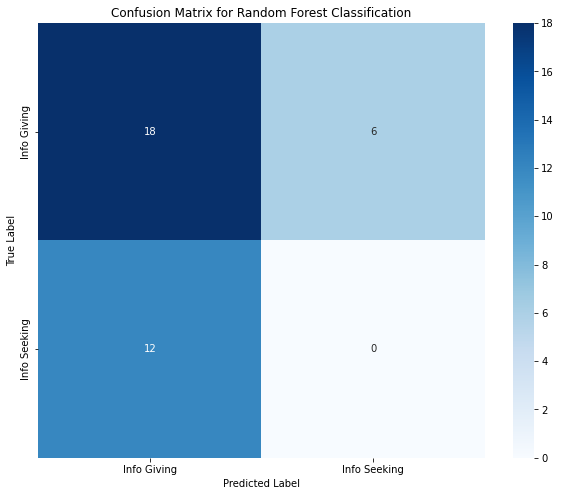

Classification Report:
              precision    recall  f1-score   support

 Info Giving       0.60      0.75      0.67        24
Info Seeking       0.00      0.00      0.00        12

    accuracy                           0.50        36
   macro avg       0.30      0.38      0.33        36
weighted avg       0.40      0.50      0.44        36



In [51]:
from sklearn.ensemble import RandomForestClassifier
# Filter out messages labeled as "Info Giving" and "Info Seeking" in df
df_two_class = df[df['Label'].isin(['Info Giving', 'Info Seeking'])]
# Filter out Code == "Auto"
df_two_class = df_two_class[df_two_class['Code'] != 'Auto']
8
# Filter out messages labeled as "Info Giving" and "Info Seeking"
X = df_two_class['Message'].values
y = df_two_class['Label'].values

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Train a random forest model
rf = RandomForestClassifier(n_estimators=100)
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20]}
clf = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
clf.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = clf.predict(X_test)

# Get the unique label names in the order of the classes
label_list = ['Info Giving', 'Info Seeking']

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=label_list)

# Create a heatmap of the confusion matrix with label names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Classification')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=label_list))


['abdomen', 'abdomen pelvis', 'able', 'access', 'additional', 'administered', 'advise', 'afternoon', 'afternoon appointment', 'afternoon appointment dr', 'afternoon wa', 'afternoon wa good', 'ago', 'anxious', 'appointment', 'appointment dr', 'appointment dr yesterday', 'appointment scheduled', 'approved', 'appt', 'appt dr', 'appts', 'april', 'april previous', 'april previous condition', 'arm', 'arm hand', 'ask', 'ask dr', 'asked', 'aug', 'august', 'available', 'aware', 'away', 'begin', 'believe', 'best', 'bid', 'billing', 'blood', 'blood test', 'blood work', 'bloodwork', 'bp', 'ca', 'ca nt', 'calcium', 'called', 'campus', 'cancer', 'cancer remain', 'cancer remain remission', 'care', 'care follow', 'care follow exam', 'cat', 'cat scan', 'cell', 'cell phone', 'certain', 'change', 'chart', 'check', 'chemo', 'chest', 'chest abdomen', 'chest abdomen pelvis', 'chiang', 'close', 'colonoscopy', 'colonoscopy dr', 'colorectal', 'colorectal cancer', 'colorectal cancer remain', 'comfortable', 'com

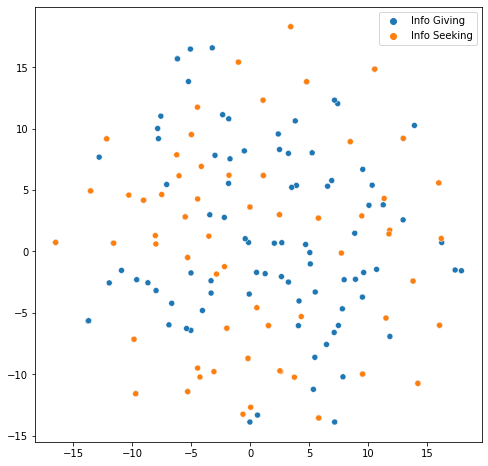

In [50]:
# Filter out messages labeled as "Info Giving" and "Info Seeking" in df
df_two_class = df[df['Label'].isin(['Info Giving', 'Info Seeking'])]
# Filter out Code == "Auto"
df_two_class = df_two_class[df_two_class['Code'] != 'Auto']
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(df_two_class['Message'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)
import gc
gc.collect()
tfIdfMatrix = np.asarray(tfIdfMat.todense())
labels = df_two_class['Label'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(8,8))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    legend="full",
    alpha=1
)

gc.collect()
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = df_two_class['Label'].tolist()
category_list = data.Label.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))  

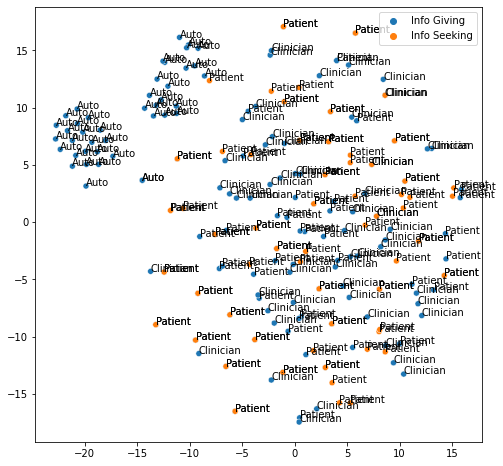

In [48]:
plt.figure(figsize=(8,8))

sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    legend="full",
    alpha=1
)
for i, txt in enumerate(df_two_class['Code']):
    plt.annotate(txt, (tsne_results[:,0][i], tsne_results[:,1][i]))
plt.show()

In [65]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# define the lemmatizer
lemmatizer = WordNetLemmatizer()

# define a function to clean and lemmatize text using nltk
def clean_and_lemmatize_text(text):
    # tokenize the text into words
    words = nltk.word_tokenize(text)
    
    # remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    
    # lemmatize the words
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # join the words back into a string
    cleaned_text = ' '.join(words)
    
    return cleaned_text

# apply the clean and lemmatize function to the 'Message' column
data = df.copy()
data['Message'] = data['Message'].apply(clean_and_lemmatize_text)

# use the tf-idf vectorizer with the cleaned and lemmatized text
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['Message'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())

feature_names

[nltk_data] Downloading package stopwords to /Users/jiqi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jiqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['abdomen',
 'able',
 'admin',
 'afternoon',
 'afternoon appointment',
 'afternoon appointment dr',
 'afternoon wa',
 'afternoon wa good',
 'ago',
 'ago going',
 'ago going initiate',
 'aka',
 'aka wife',
 'amp',
 'android',
 'android prepare',
 'android prepare lt',
 'answer',
 'anxious',
 'app',
 'app phone',
 'app phone tablet',
 'apple',
 'apple prepare',
 'apple prepare mychart',
 'application',
 'application original',
 'application original appointment',
 'appointment',
 'appointment dr',
 'appointment dr yesterday',
 'appointment information',
 'appointment information department',
 'appointment information visit',
 'appointment medical',
 'appointment medical surgical',
 'appropriate',
 'appropriate link',
 'appropriate link help',
 'approval',
 'approval chair',
 'approval chair designee',
 'approved',
 'approved insurance',
 'approved insurance point',
 'appt',
 'appt dr',
 'appt instruction',
 'appt instruction make',
 'appt status',
 'appt status scheduled',
 'april',
 'ap